Get TopicTuner from github

In [1]:
!git clone  https://github.com/drob-xx/TopicTuner.git

Cloning into 'TopicTuner'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 300 (delta 18), reused 18 (delta 9), pack-reused 269
Receiving objects: 100% (300/300), 272.87 KiB | 0 bytes/s, done.
Resolving deltas: 100% (170/170), done.


Place TopicTuner on the path

In [10]:
from TopicTuner.topictuner import TopicModelTuner as TMT
from utils import load_anno_data
import pandas as pd
from collections import Counter


Get 20NewsGroup data

Create a TMT instance from scratch

In [37]:
df = pd.read_csv('../data/annotated_target_topic_data.csv')
hate_df = df[df['label']=='hatespeech']
# docs = [' '.join(x) for x in df.tokens.values]
# hate_df = hate_df[hate_df['target'].isin({'Asian', 'Other', 'None', 'Women', 'Hispanic'})]
hate_df[hate_df['target']=='Arab']['target'] = 'Islam'
labels_counter = Counter(hate_df.target.tolist())
hate_df = hate_df[hate_df['target'].isin(x[0] for x in labels_counter.most_common(4))]


In [82]:
hate_df.target.unique()

array(['Jewish', 'African', 'Islam', 'Homosexual'], dtype=object)

Alternatively, you can create one from an existing BERTopic instance by calling 

newTMT = TMT.wrapBERTopicModel(<your BERTopic model>)

Create the embeddings.

In [39]:
tmt = TMT()
docs = list(hate_df.text.values)
tmt.createEmbeddings(docs)

Then reduce them to 5 features ala BERTopic byt calling TMT.reduce()

In [40]:
tmt.reduce()

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=5, n_neighbors=5, verbose=2)
Sat Jan 14 21:23:46 2023 Construct fuzzy simplicial set
Sat Jan 14 21:23:46 2023 Finding Nearest Neighbors
Sat Jan 14 21:23:46 2023 Building RP forest with 8 trees
Sat Jan 14 21:23:46 2023 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	 7  /  12
	 8  /  12
	Stopping threshold met -- exiting after 8 iterations
Sat Jan 14 21:23:46 2023 Finished Nearest Neighbor Search
Sat Jan 14 21:23:46 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Jan 14 21:23:51 2023 Finished embedding


Now we can explore different HDBSCAN settings for this instance of the UMAP reductions.

TMT.randomSearch takes two arrays as arguments. By default it will execute 20 searches, randomly selecting the values passed in the first array as the min_cluster_size. The decimal float values in the second array will be randomly selected and then multiplied with the selected min_cluster_size to determine a sample_size.

Note that the values for in each of these search examples below will likely have to be modified to give you optimized results for your specific UMAP reduction.

In [41]:
lastRunResultsDF = tmt.randomSearch([*range(300,600)], [.1, .25, .5, .75, 1], 40)

  0%|          | 0/40 [00:00<?, ?it/s]

Each time a TMT search is performed all the results are collected in the TMT.ResultsDF DataFrame. Each search returns a DataFrame with just the results of that search.

TMT.visualizeSearch produces a plotly parallel coordinates graph. You can pass it TMT.ResultsDF to get a view of all the searches, or pass it the results from a particular search.

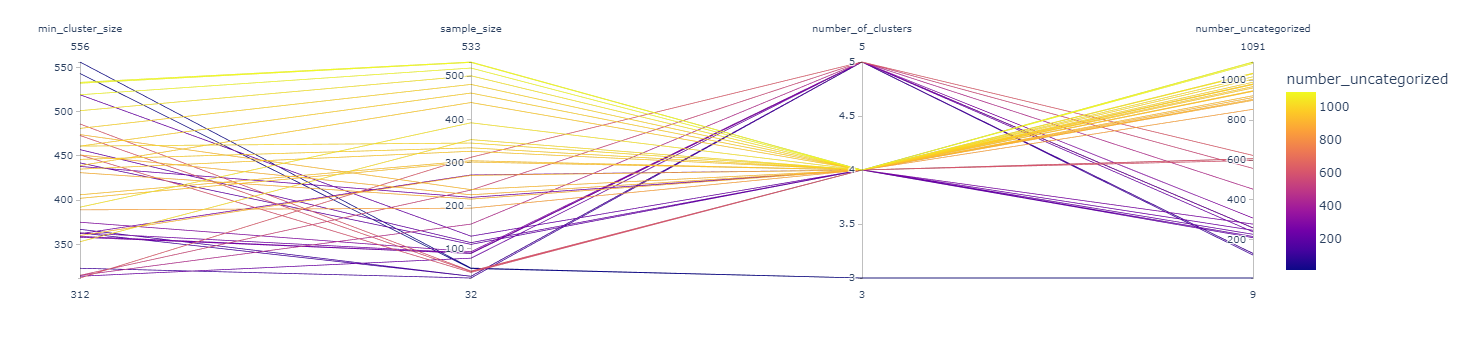

In [42]:
tmt.visualizeSearch(lastRunResultsDF).show()

TMT.summarizeResults sorts a results table by number_of_cluster and selects the 'best' value for that number of clusters by choosing the one with the least uncategorized results.

In [43]:
tmt.summarizeResults(lastRunResultsDF).sort_values(by=['number_uncategorized'])

,min_cluster_size,sample_size,number_of_clusters,number_uncategorized
0,543,54,3,9
2,323,32,5,124
1,442,110,4,211


In [44]:
best_range = range(323,326)

TMT.gridSearch() is suitable once you have narrowed down the ranges. It will search ALL the min_cluster_size values passed with each of the percentage values being evaluated to the given sample_size value. In the example below 15 runs will be performed - five different sample_sizes for each of the three min_cluster_size values - 131, 132, 133.

In [45]:
lastRunResultsDF = tmt.gridSearch([*best_range], [.1, .25, .5, .75, 1])

  0%|          | 0/15 [00:00<?, ?it/s]

In [46]:
tmt.summarizeResults(lastRunResultsDF).sort_values(by=['number_uncategorized'])

,min_cluster_size,sample_size,number_of_clusters,number_uncategorized
1,323,32,5,124
0,323,323,4,955


Once you have narrowed down the values of interest further you may want to run a more thorough search to do this. TMT.simpleSearch takes two arrays as arguments. The first are the min_cluster_sizes and the second are the sample_sizes. You might prepare these lists like this:

In [48]:
csizes = []
ssizes = []
for csize in [*best_range] :
  for ssize in range(1, csize+1) :
    csizes.append(csize)
    ssizes.append(ssize)

In the above example csizes is a list of 131 values of 131. ssizes is 131 values of 1 to 131. This runs ALL possible sample sizes (131) for the min_cluster_size of 131. The first run will be min_cluster_size=131, sample_size=1, the second min_cluster_size=131, sample_size=2 etc.

In [49]:
lastRunResultsDF = tmt.simpleSearch(csizes, ssizes)

  0%|          | 0/972 [00:00<?, ?it/s]

TMT can generate a scatterplot of your embeddings overlayed with the clustering of a given set of parameters. This can assist in deciding how many clusters to select for your model.

To accomplish this, first you must create a 2D reduction of the embeddings suitable for a 2D scatterplot.

In [50]:
tmt.createVizReduction()

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_neighbors=5, verbose=2)
Sat Jan 14 21:32:13 2023 Construct fuzzy simplicial set
Sat Jan 14 21:32:13 2023 Finding Nearest Neighbors
Sat Jan 14 21:32:13 2023 Building RP forest with 8 trees
Sat Jan 14 21:32:13 2023 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	 7  /  12
	 8  /  12
	Stopping threshold met -- exiting after 8 iterations
Sat Jan 14 21:32:13 2023 Finished Nearest Neighbor Search
Sat Jan 14 21:32:13 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Jan 14 21:32:19 2023 Finished embedding


In [51]:
lastRunResultsDF.sort_values(by=['number_uncategorized'])

,min_cluster_size,sample_size,number_of_clusters,number_uncategorized
333,324,11,5,79
654,325,8,5,79
655,325,9,5,79
656,325,10,5,79
658,325,12,5,79
...,...,...,...,...
638,324,316,4,961
962,325,316,4,961
640,324,318,4,961
315,323,316,4,961


In [52]:
best_params = (324,11)

If TMT has access to the docs it will use them to add document text to the scatterplot.

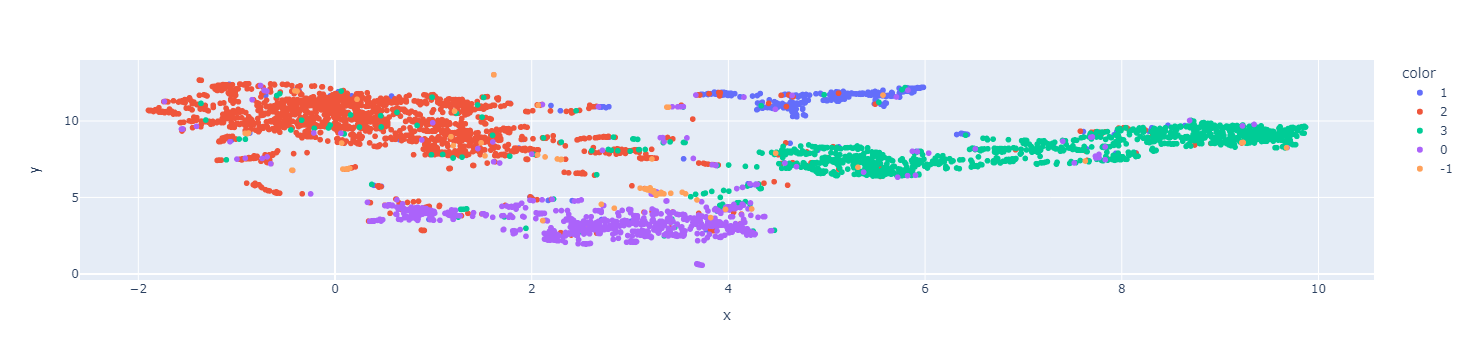

In [53]:
tmt.visualizeEmbeddings(*best_params).show()

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english")
bt = tmt.getBERTopicModel(*best_params)
bt.vectorizer_model=vectorizer_model
bt.umap_model = tmt.reducer_model
topics = bt.fit_transform(docs)


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=5, n_neighbors=5, verbose=2)
Sat Jan 14 21:57:22 2023 Construct fuzzy simplicial set
Sat Jan 14 21:57:22 2023 Finding Nearest Neighbors
Sat Jan 14 21:57:22 2023 Building RP forest with 8 trees
Sat Jan 14 21:57:22 2023 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	 7  /  12
	 8  /  12
	Stopping threshold met -- exiting after 8 iterations
Sat Jan 14 21:57:22 2023 Finished Nearest Neighbor Search
Sat Jan 14 21:57:22 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Jan 14 21:57:27 2023 Finished embedding


In [65]:
bt.transform(['I hate jews'])

Sat Jan 14 21:49:33 2023 Worst tree score: 0.18536991
Sat Jan 14 21:49:33 2023 Mean tree score: 0.20064422
Sat Jan 14 21:49:33 2023 Best tree score: 0.22194514
Sat Jan 14 21:49:33 2023 Forward diversification reduced edges from 24060 to 15475
Sat Jan 14 21:49:33 2023 Reverse diversification reduced edges from 15475 to 15475
Sat Jan 14 21:49:33 2023 Degree pruning reduced edges from 16958 to 16302
Sat Jan 14 21:49:33 2023 Resorting data and graph based on tree order
Sat Jan 14 21:49:33 2023 Building and compiling search function


Epochs completed:   0%|            0/100 [00:00]

([1], array([1.]))

In [80]:
bt.get_topic_info()

,Topic,Count,Name
0,0,1945,0_nigger_white_niggers_number
1,1,1324,1_kike_jews_jew_white
2,2,1090,2_moslem_muslim_number_islam
3,3,426,3_faggots_faggot_queers_dykes
4,-1,27,-1_coons_anglin_coon_giant


In [84]:
hate_df['topics'] = [bt.topic_names[x] for x in topics[0]]

In [92]:
target_labels = {'Jewish':1, 'African':0, 'Islam':2, 'Homosexual':3}
hate_df['encoded_target'] = [target_labels[x] for x in hate_df['target'].values]
hate_df['encoded_topics'] = topics[0]

In [110]:
g_hate_df

Unnamed: 0  label  tokens  text  \
topics                        target                                        
-1_coons_anglin_coon_giant    African             24     24      24    24   
                              Jewish               3      3       3     3   
0_nigger_white_niggers_number African           1734   1734    1734  1734   
                              Homosexual          94     94      94    94   
                              Islam               66     66      66    66   
                              Jewish              51     51      51    51   
1_kike_jews_jew_white         African            174    174     174   174   
                              Homosexual          61     61      61    61   
                              Islam               50     50      50    50   
                              Jewish            1039   1039    1039  1039   
2_moslem_muslim_number_islam  African            138    138     138   138   
                              Homosexual          48     48      48    48   
                              Islam              875    875     875   875   
                              Jewish              29     29      29    29   
3_faggots_faggot_queers_dykes African             55     55      55    55   
                              Homosexual         335    335     335   335   
                              Islam               27     27      27    27   
                              Jewish               9      9       9     9   

                                          encoded_target  encoded_topics  
topics                        target                                      
-1_coons_anglin_coon_giant    African                 24              24  
                              Jewish                   3               3  
0_nigger_white_niggers_number African               1734            1734  
                              Homosexual              94              94  
                              Islam                   66              66  
                              Jewish                  51              51  
1_kike_jews_jew_white         African                174             174  
                              Homosexual              61              61  
                              Islam                   50              50  
                              Jewish                1039            1039  
2_moslem_muslim_number_islam  African                138             138  
                              Homosexual              48              48  
                              Islam                  875             875  
                              Jewish                  29              29  
3_faggots_faggot_queers_dykes African                 55              55  
                              Homosexual             335             335  
                              Islam                   27              27  
                              Jewish                   9               9

In [157]:
g_hate_df = hate_df.groupby(['topics', 'target']).count()['label'].reset_index()
p_g_hate_df = g_hate_df.pivot_table(columns=g_hate_df.topics, index=g_hate_df.target)
p_g_hate_df.columns = p_g_hate_df.columns.droplevel(0)
p_g_hate_df = p_g_hate_df.reindex(['African', 'Jewish', 'Islam', 'Homosexual'])
n_p_g_hate_df = p_g_hate_df.apply(lambda x: x/x.sum(), axis=1).drop(columns=['-1_coons_anglin_coon_giant'])


<AxesSubplot:xlabel='topics', ylabel='target'>

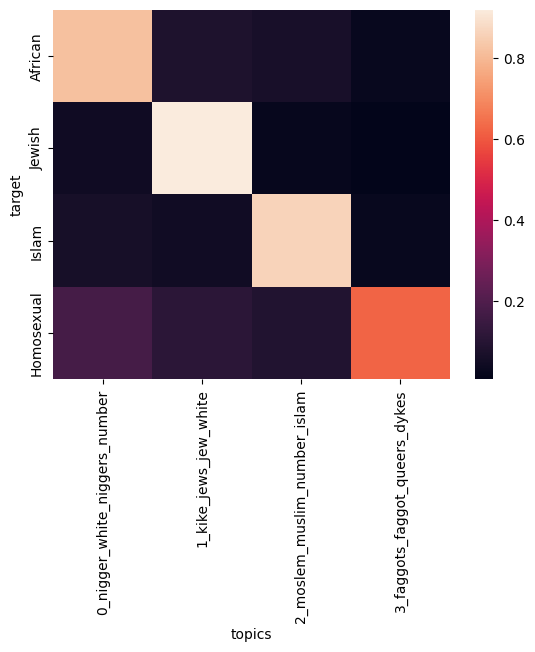

In [158]:
import seaborn as sns
sns.heatmap(n_p_g_hate_df)

In [159]:
bt.save('model')

Sat Jan 14 23:05:51 2023 Worst tree score: 0.20157938
Sat Jan 14 23:05:51 2023 Mean tree score: 0.21061929
Sat Jan 14 23:05:51 2023 Best tree score: 0.22734830
Sat Jan 14 23:05:51 2023 Forward diversification reduced edges from 24060 to 15426
Sat Jan 14 23:05:51 2023 Reverse diversification reduced edges from 15426 to 15426
Sat Jan 14 23:05:51 2023 Degree pruning reduced edges from 16934 to 16283
Sat Jan 14 23:05:51 2023 Resorting data and graph based on tree order
Sat Jan 14 23:05:51 2023 Building and compiling search function


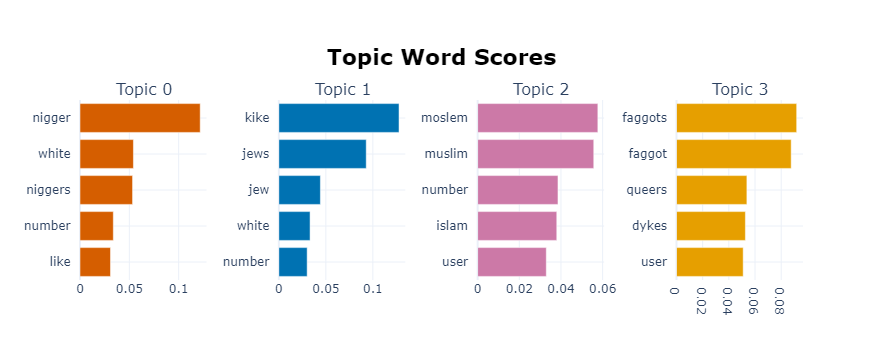

In [85]:
bt.visualize_barchart()

You can save your TMT model with TMT.save()

You can save your TMT model with TMT.save()

In [23]:
tmt.save('temp')

Sun Jan  8 00:05:59 2023 Worst tree score: 0.14845146
Sun Jan  8 00:05:59 2023 Mean tree score: 0.15608663
Sun Jan  8 00:05:59 2023 Best tree score: 0.16487989
Sun Jan  8 00:06:02 2023 Forward diversification reduced edges from 100740 to 65734
Sun Jan  8 00:06:04 2023 Reverse diversification reduced edges from 65734 to 65734


/home/shouei/.conda/envs/bert2vec/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



Sun Jan  8 00:06:06 2023 Degree pruning reduced edges from 73068 to 70571
Sun Jan  8 00:06:06 2023 Resorting data and graph based on tree order
Sun Jan  8 00:06:06 2023 Building and compiling search function
Sun Jan  8 00:06:08 2023 Worst tree score: 0.15182648
Sun Jan  8 00:06:08 2023 Mean tree score: 0.15777000
Sun Jan  8 00:06:08 2023 Best tree score: 0.16790748
Sun Jan  8 00:06:08 2023 Forward diversification reduced edges from 100740 to 65879
Sun Jan  8 00:06:08 2023 Reverse diversification reduced edges from 65879 to 65879
Sun Jan  8 00:06:08 2023 Degree pruning reduced edges from 73194 to 70692
Sun Jan  8 00:06:08 2023 Resorting data and graph based on tree order
Sun Jan  8 00:06:08 2023 Building and compiling search function


/home/shouei/.conda/envs/bert2vec/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



And restore it using TMT.load()

In [3]:
tmt2 = TMT.load('temp')

Sun Jan  8 22:05:26 2023 Building and compiling search function
Sun Jan  8 22:05:29 2023 Building and compiling search function


Once you have determined parameters that work for your text, TMT can manufacture a BERTopic model. Note in this example we pass BERTopic the embeddings created earlier - no need to have BERTopic re-run them.

In [5]:
bt1.save('bert_model')

In [100]:
topic2label = {'0_nigger_the_to_and':'African', '1_kike_the_jews_to':'Jewish','2_the_to_and_of':'?','-1_islam_the_and_to':'Islam', '3_the_you_to_user':'?'}

In [41]:
df.to_csv('../data/annotated_target_topic_data.csv')

In [103]:
hate_df['topic_target'] = hate_df['topics'].apply(lambda x: topic2label[x])

In [113]:
(hate_df['target'] == hate_df['topic_target']).sum()/len(hate_df)

0.48684632659608595